# Text Classification Problem

Here I will address a text classification problem: trying to predict whether a given tweet is about a real disaster or not. In particular I propose you the scenario presented at the [Real or Not? NLP with Disaster Tweets Kaggle Competition.](https://www.kaggle.com/c/nlp-getting-started/leaderboard). 

To that, I will make use of the text classification models explained in class, which are included in sklearn.
Before applying any algorithm, I have to create the data structures needed (document-term matrix) and we have to process the textual data (tokenization, stemming, ...).

To improve the performance of the classifiers, I will also apply some more advanced NLP processing methodologies, such as: different weighting schemas, using n-grams.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
from matplotlib import interactive
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

# Needed Libraries
import sys
import pandas
import pandas as pd
import numpy as np
import operator
import string
import re

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer



from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit


# Dataset Loading

Making use of pandas and sklearn, we load and prepare the dataset for the training step

In [2]:
# Dataset Loading
training_set = pandas.read_csv("./train.csv", quotechar='"', header=0, sep=",")
test_set = pandas.read_csv("./test.csv", quotechar='"', header=0, sep=",")

In [3]:
training_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


As you can see, the training set contains the dependent variable (1 or 0, real or not) as well as some independent variables. We have some metadata in the tweets that I will later analyze to see if it makes sense to include them in the models.

In [4]:
test_set.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test set contains the same independent variables, but no label whatsoever. This is the common scenario proposed by Kaggle. You get a training set to create your models and then you have to use these models to predict over the test set.

# Inspecting the data

In this section I intend to take a closer look to the dataset, especially to the textual content to make sense what kind of methodologies make sense. Thanks to it it's possible to understand what kind of data I have, what kind of NLP steps can be of any use or even if there's enough data to train the models and create a valid solution.

**First I'm going to inspect the distribution of the classes to see if they are unbalanced**

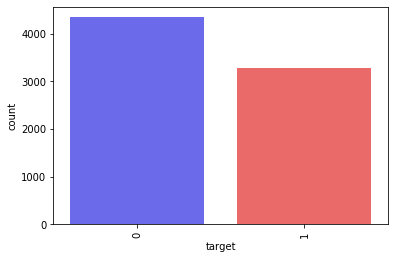

In [5]:
from collections import Counter
sns.countplot(training_set.target, order=[x for x, count in sorted(Counter(training_set.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

As seen in the figure, There are a slight difference between the number of tweets at each class but nothing to worry about.

**Looking at metadata**

2 pieces of information:

 - keyword: the keyword used as query to retrieve the tweets
 - location: Location of the user posting the tweet
 
Regarding the **keywords**, some of them can be strongly related to a given category, but they can also be highly ambiguous as it's possible to see in the following figure (I used the code in this kernel to create it: https://www.kaggle.com/grantgasser/eda-naive-bayes-bert-glove-fasttext-nn).


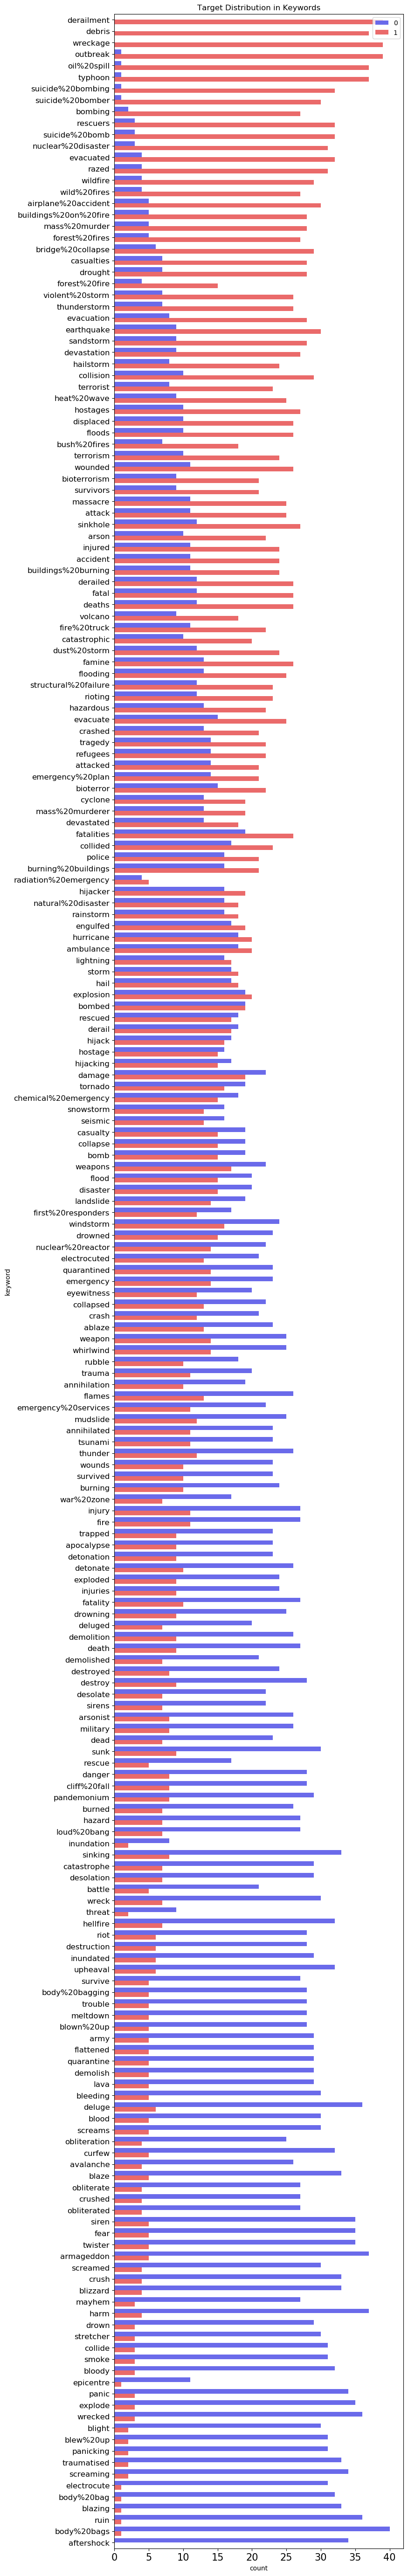

In [6]:
# Copy the dataframes to be able to come back to the original version
df_train = training_set.copy()
df_test = test_set.copy()

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], palette='seismic')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Given that the keywords are already included in the textual content (the tweets have been retrieved because they include some of the keywords), I have decided to discard this information as I expect we can learn the importance of the keywords as individual tokens in the textual content. 

Let's analyze the **location**.

The first aspect to consider is that it has many null values

In [7]:
print("% of null columns =", (len(training_set.location) - training_set.location.count())/len(training_set))

% of null columns = 0.33272034677525286


This is a common features of any twitter dataset. For privacy reasons, many people prefer to keep their locations to themselves. This could change in the case of a disaster. You may want to share your location to give a better understanding of the disaster.

I will only focus on the textual information (`text` column) of the dataset.

At this point we have to options:

- Focus just on the actual textual content by applying the NLP methodologies addressed in class for text classification
- Increase the information in the dataset by feature-engineering some new features derived from the textual content (e.g., lenght of the tweets, how many stopwords in the tweets, how many urls...).
    
To further analyze if this idea makes sense, I have used the code in this kernel (https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) to create some of these features and plot them against the target variable

In [7]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

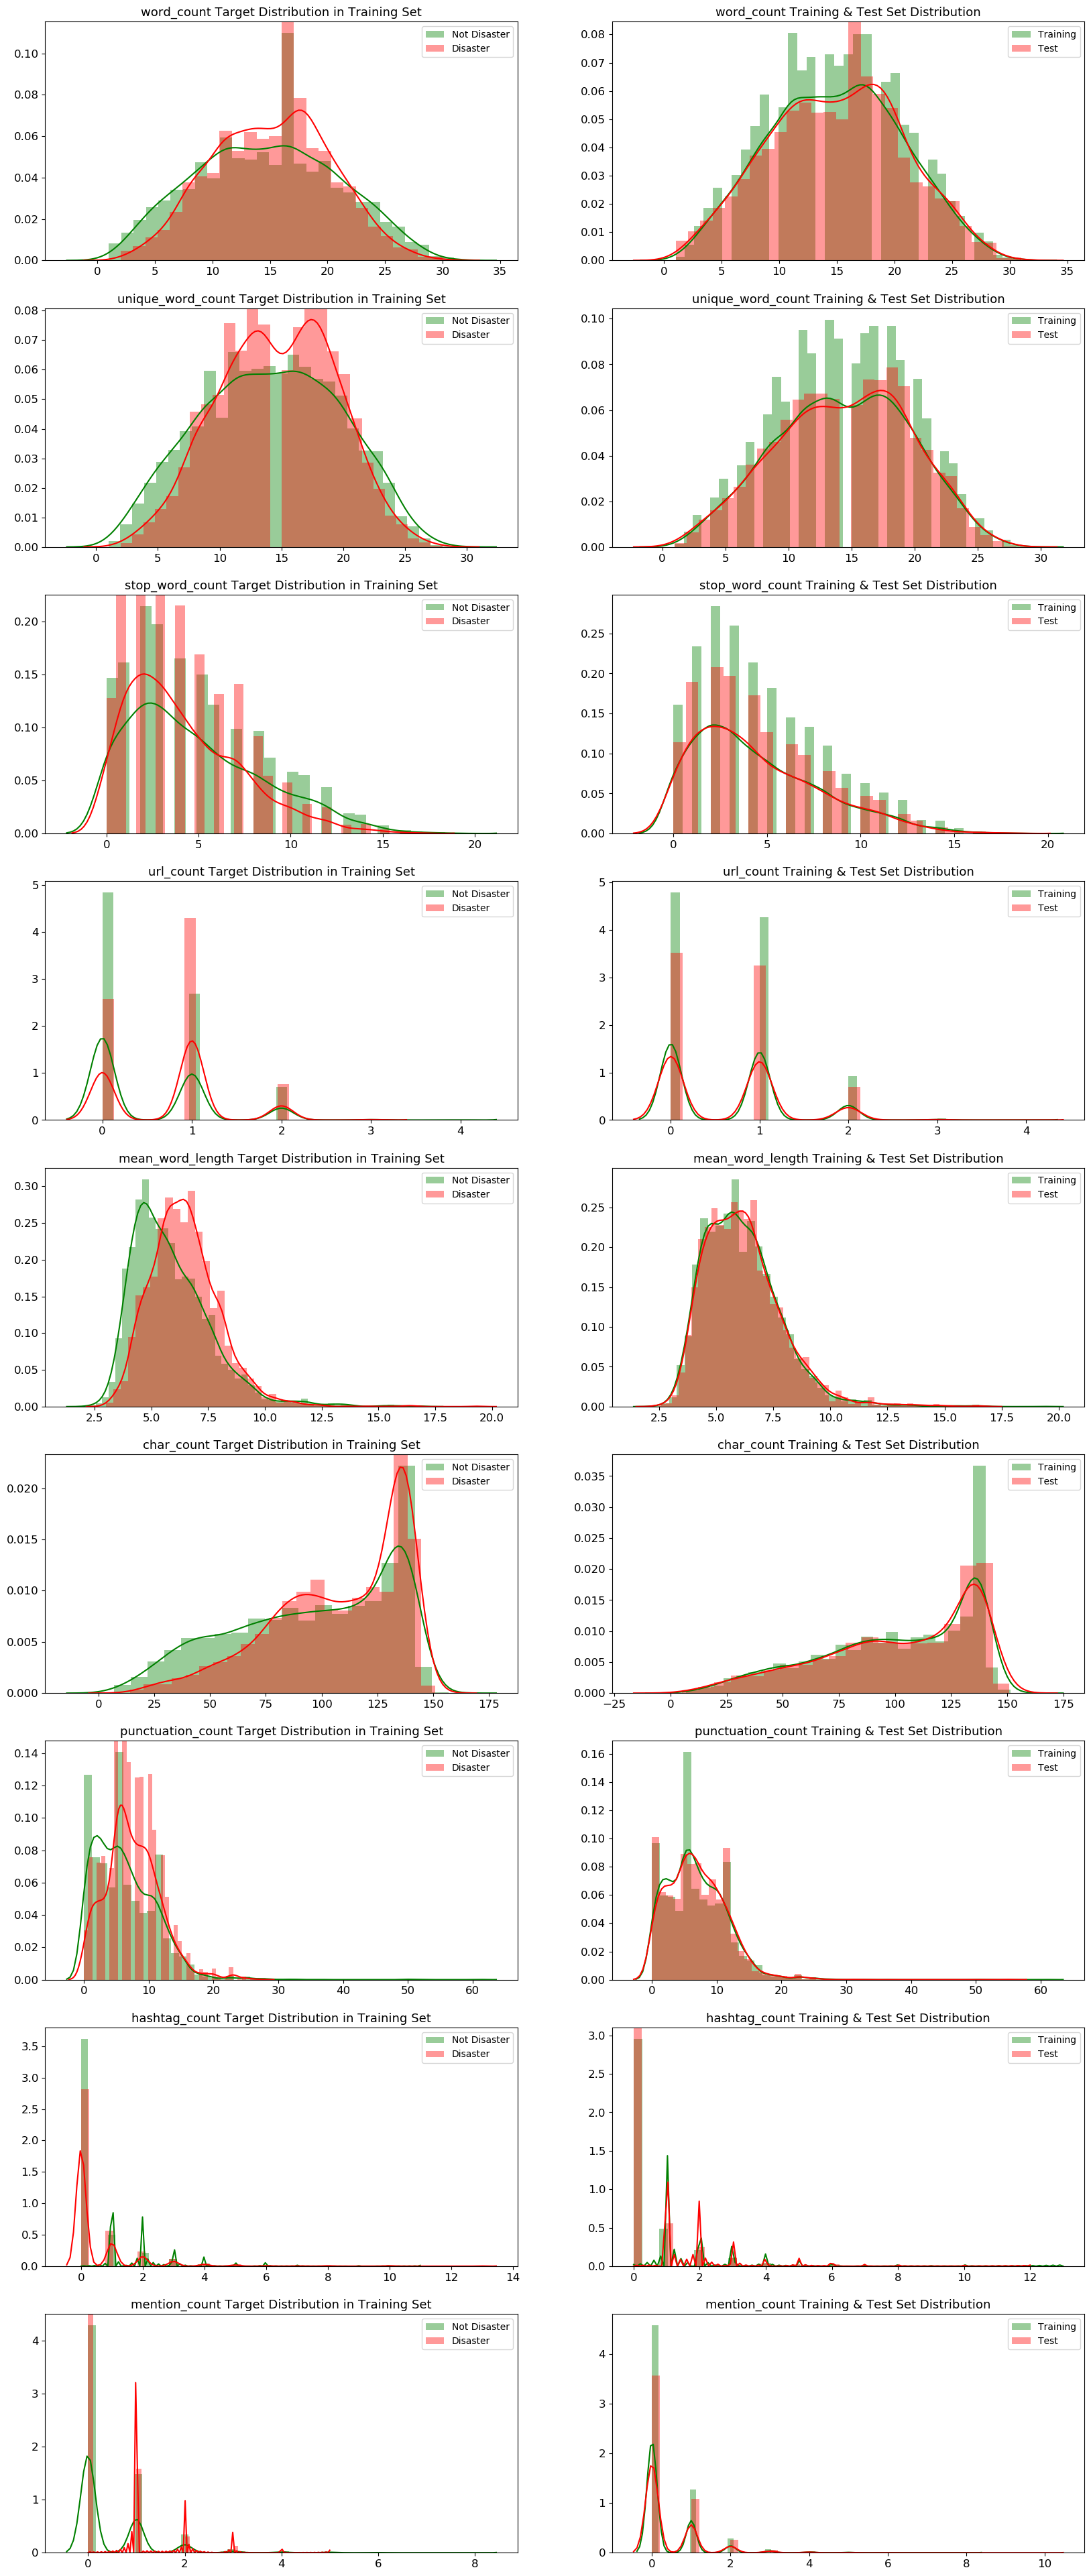

In [9]:
import warnings
warnings.filterwarnings('ignore')

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1], color='green')
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1], color='red')
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

These figures shows the comparison between the class disaster and not disaster in the training set (on the left) and the comparison between the training and test datasets (on the right) for the different derived features.

In general terms, they do not provide any interesting insight. The distribution of all of these new features are basically the same in both classes and datasets. Consequently, I do not expect them to be of any help for creating the classification models (or at least I do not expect their impact to be large enough to motivate their use). At a closer inspection, the length of the tweets seems to be slightly different between the classes.

Anyhow, I have decided to just use the textual information without any new feature to create my models

**Inspecting the actual text of the tweets belonging to each class.**

In the following figure we plot the most common words in each class.

In [18]:
def plot_most_common_features(text_col, target_col, n_features=50):

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(15,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

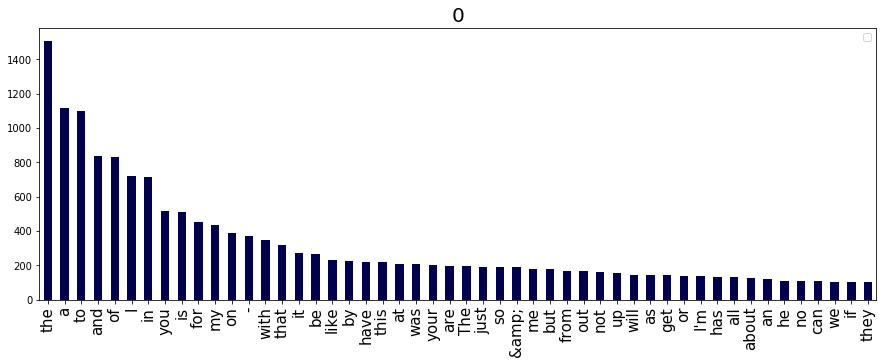

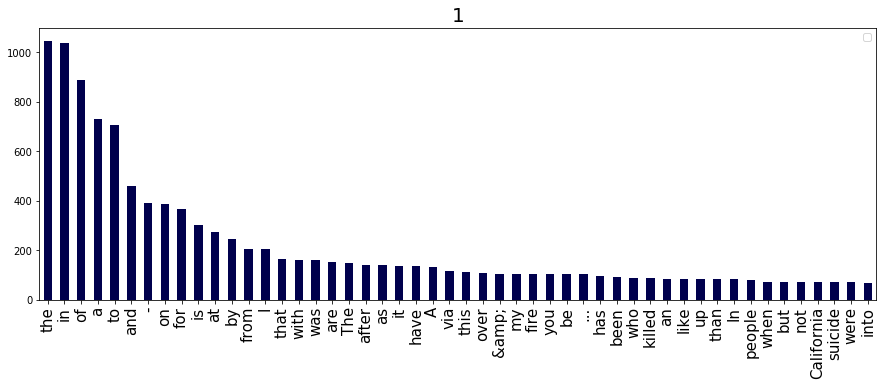

In [19]:
plot_most_common_features(training_set.text, training_set.target)

Well, this first inspection has been quite a dissapointment.

By plotting the most repeated words in each class we expected to see the words "most representative" of each class. If they were different enough, this will indicate us that we can use them to easily identify the classes.

However, what we see is the same set of uninformative words for both classes. What we are seeing are mostly **stopwords** which are not related to the class and might affect the final classifier. It seems that we will have to remove them latter.

Another issue that we can detect with this inspection is that we have words like `A` and `a` which are the same but are considered as a different term because of the capitalization. It shows that we will have to **normalize** the words.

In addition, we find different forms of the same verb: `are`, `be`, `is`. There are two methodologies to extract the basic form of a word: **stemming and lemmatization**. Stemming will not solve this problem. As seen in class, it finds the basic forms (stems) by chunking the words. In contrast, by lemmatizing the words we will find the basic form of the words (`be` for the words `are`, `be` and `is`).
In any case, it may be worthy to try both approaches.

# Text Processing and Data Preparation


I will start with a basic Natural Language Pre-processing
 - Extract English Words
 - Lemmatize text to exclude repeated words with same root
 - Stem words to avoid over counting same meaning words
 - Removing stop words


In [20]:
dataset = pandas.concat([training_set,test_set], sort=True)

To encapsulate this process and facilitate its application, a `process_text`function is created, which encloses all the text processing

In [21]:
def process_text(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in not_stop_words]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in lemmatized]
    
    return( " ".join( stemmed ))  

I now apply this function to the textual content.
Just in case we need the raw text later, I will create new columns to store the processed text.

In [22]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

,id,keyword,location,target,text,clean_text
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv u
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


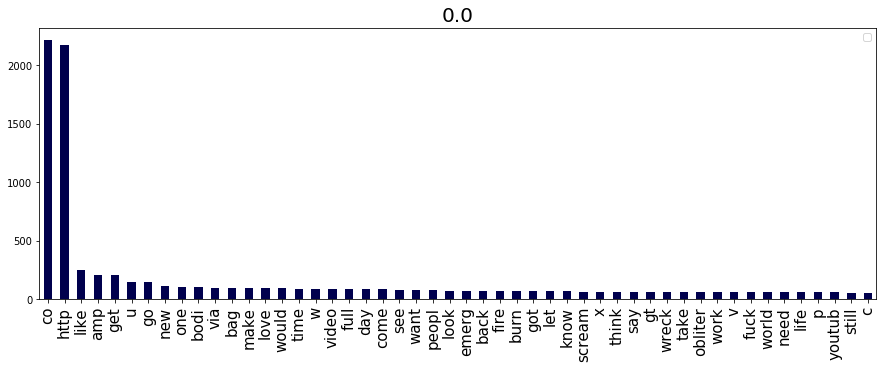

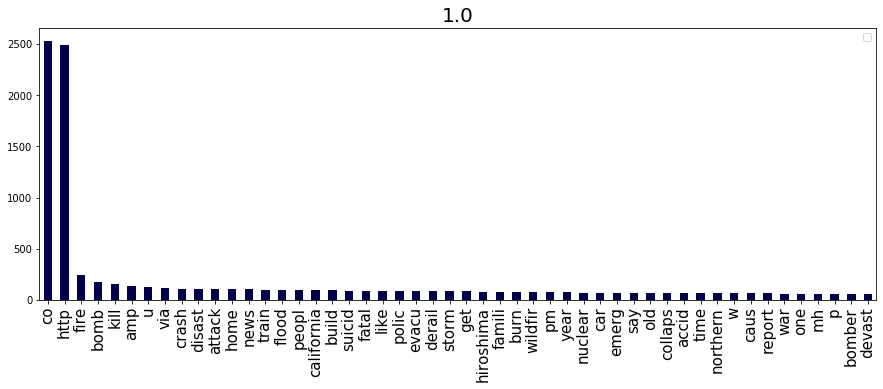

In [23]:
plot_most_common_features(dataset.clean_text, dataset.target)

It looks much better now.
I have removed all the stopwords and the terms that we see now are much more representative (e.g., `bomb`, `crash` among the tweets about actual disasters).

However, we also see another meaningless words (e.g., `co`, `http`) in both classes. This kind of terms are known as domain-stopwords. I.e., they are not stopwords of the English language but they are very common terms in our particular domain (e.g., HTML keywords). As I cannot see how they can inform about the category of the tweet, I have decided to remove them.

To that end, I am going to modify the `process_text` to clean all of the possible domain stopwords that I can find in the textual content of the tweets. I have found the following function in this Kaggle kernel: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert


In [24]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
 
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    return tweet

In [25]:
def process_text(raw_text):
    raw_text = clean(raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english"))  
    not_stop_words = [w for w in words if not w in stops]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in not_stop_words]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in lemmatized]
    
    return( " ".join( stemmed )) 

In [26]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

,id,keyword,location,target,text,clean_text
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv u
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [57]:
# Saving model

dataset.to_csv('./cleaned_dataset.csv', sep=",", quotechar='"')

As you can see, this extensive function uses regular expression to capture different stopwords, as well as other issues and domain-dependent content, and clean them.

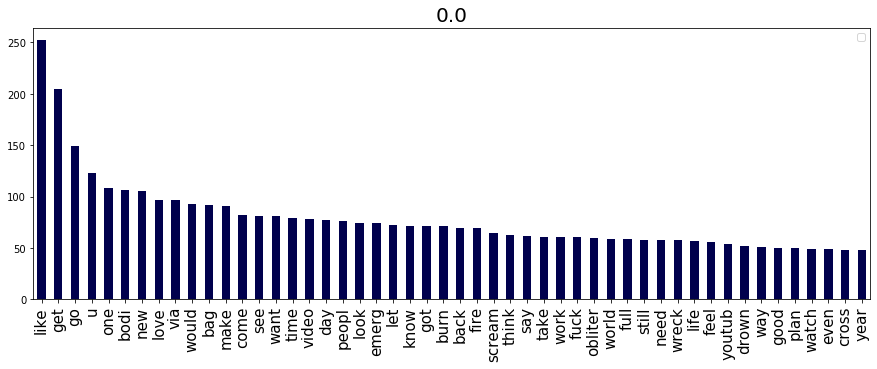

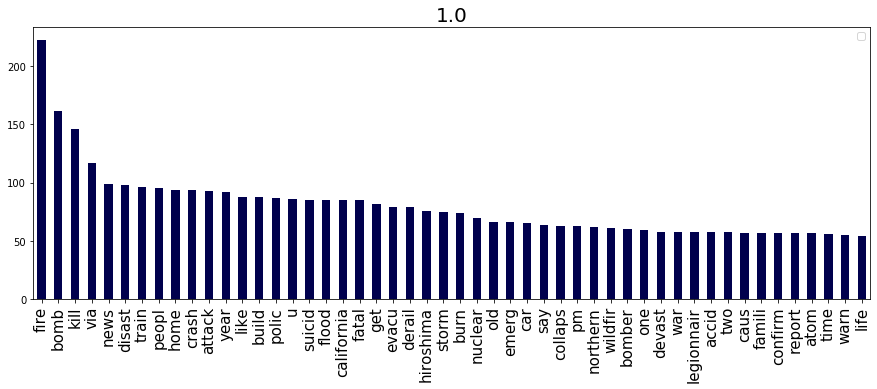

In [58]:
plot_most_common_features(dataset.clean_text, dataset.target)

Right, now we only see what appears to be relevant terms among the most common ones. Let's move on to the next step: creating the machine learning models for text classification


# Modelling

As discussed in class, simple classification tasks can be solved by means of hand-coded rules or simple heuristics. However, as soon as you address more realistic (complex) scenarios you need Machine Learning to create a valid text classifier. In this section I will make use of some of the classification approaches explained in class and I will compare them to decide which one makes sense for this scenario. In addition, I will try different ideas to further improve the performance of my classifiers via some NLP related procedures (TF-IDF, ngrams....)

The first thing to do is to divide our dataset to get the original training and test datasets (based on what was provided by the Kaggle competition).


In [59]:
X_train = dataset[0:len(training_set)][["id", "clean_text", "text"]]
y_train = dataset[0:len(training_set)][["target"]]
X_test = dataset[len(training_set):len(dataset)][["id", "clean_text", "text"]]
y_test = dataset[len(training_set):len(dataset)][["target"]]

Labels are in string format. It is preferred to have them numerically encoded. To that end, sklearn provides a `LabelEncoder` to facilitate this encoding

In [60]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.target.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.target.values)

**Vector Space Model**

We then need to convert the textual content into numerical feature vectors (i.e., Vector Space Model), applying the bags of words representation:

 - Assign an id to each word of the training set.
 - For each document `d`, count the number of occurrences of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Sklearn has also some useful functions for this textual processing that we will make use of.

I am going to use the `CountVectorizer` for creating the feature vectors, which returns the Document-Term Matrix.

At this point it is important to remark something. The `CountVectorizer` has two methods, `fit_transform` and `transform`. The first one creates the vectorization (i.e., converts the strings to vectors by by creating a dimension for each one of the words in the vocabulary: `'aa':0, aaron:1, ...., zzx:'40000'`) and applies it to the given dataset (the training dataset). The `transform` method uses the vectorization previously created by `fit_transform` and applies it to the given dataset (test). If we use the `fit_transform` again with the test test we will create a new vectorization, potentially different from the one created to the training set. Consequently, same words can be codified with different positions in training and test, making impossible to work with them.

In [61]:
count_vect = CountVectorizer(analyzer = "word") 

train_text_features = count_vect.fit_transform(X_train.clean_text)
test_text_features = count_vect.transform(X_test.clean_text)

Now I have the dataset in the needed format, that will allow me to create the baseline models

To train, evaluate and compare the models I've created a function `train_and_evaluate_classifier` that takes the training data, a classifier definition and a grid to optimize the classifier to train a predictive model. I have used the F1 metric as the scoring function to train the model given that this is the metric used in the Kaggle Competition.

In [72]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 5, scoring='f1')
    
    # Train the model over and tune the parameters
    print("Training model")
    classifier.fit(X, yt)

    # CV-score
    print("CV-scores for each grid configuration")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print()

    return classifier

Finally I'm going to create a DataFrame to track the performance of the different approaches

In [100]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])

## Approach #1: Naïve Bayes

Let's apply Naïve Bayes for the textual classification.
Note: In order to predict the class of a given document we compute the "Maximum Apriori Probability":

\begin{equation*}
MAP   = max({P(c_1|w_1,...w_n), P(c_2|w_1,...,w_n)})
\end{equation*}

To compute $P(c|w_1,...w_n)$, we will use the Bayes theorem:

\begin{equation*}
P(c|w_1,...w_n) = \frac{P(w_1,...,w_n|c)P(c)}{P(w_1,...,w_n)}
\end{equation*}

Being "naive", we can assume that w_1, ..., w_n are independent among them. Therefore:

\begin{equation*}
P(w_1,...,w_n|c) = P(w_1|c)P(w_2|c) ... P(w_n|c)
\end{equation*}

I will use the column `clean_text` to create the features through the count vectorizer object

In [93]:
nb_text_cls = train_and_evaluate_classifier(train_text_features, encoded_y_train, MultinomialNB(), {})

Training model
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV-scores for each grid configuration
Accuracy: 0.764 (+/-0.021) for params: {}



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


In [101]:
results_df.loc[len(results_df)] = ['NB Baseline', 0.764]
results_df

,Approach,Accuracy
0,NB Baseline,0.764


0.76 of F-Measure is a strong baseline. In this solution I am going to explore more solutions to further enhance these results. Nevertheless, if you are trying to create a production system, it could be enough. As you could have seen, it is quite easy and fast to train a NB classifier. 

Only if you actually need a state of the art classifier you could delve into the following methodologies.

## Approach 2: SVM

As seen in class, SVM is better suited for text classification, providing a more accurate model. By making use of sklearn, I'm going to implement a SVM classifier and check if it's possible to improve the baseline Naïve Bayes model.


We now make use of the `train_and_evaluate_classifier` function

In [99]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [10,100,1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
 ]

svm_cls = train_and_evaluate_classifier(train_text_features, encoded_y_train, SVC(class_weight='balanced'), svm_grid)

Training model
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.3min finished


CV-scores for each grid configuration
Accuracy: 0.766 (+/-0.020) for params: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.765 (+/-0.020) for params: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.754 (+/-0.004) for params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.741 (+/-0.007) for params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.741 (+/-0.008) for params: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.739 (+/-0.006) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.726 (+/-0.031) for params: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.684 (+/-0.042) for params: {'C': 0.01, 'kernel': 'linear'}
Accuracy: 0.510 (+/-0.126) for params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}



In [102]:
results_df.loc[len(results_df)] = ['SVM', 0.77]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770


0.77 of F measure. As expected, better than the baseline model based on NB, although very slightly.
Usually, SVM is a more suited algorithm for text classification than Naive Bayes. It's arguable if the increase in complexity is justified by the increase in performance. In this case, it seems that it does not make so much sense. 

I'm going to try MaxEnt Classifier to check if we can improve our baseline.

## Approach 3: MaxEnt Classifiers

In class we studied the maxent classifiers. They are probabilistic models especially suited for text classification since they do not assume any independence between the textual contents.
They are expected to offer better results than simple NB without the complexity of SVM. Let's try it.

In [110]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l2'], 'C': np.logspace(-2, 2, 20)}
max_ent_cls = train_and_evaluate_classifier(train_text_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


CV-scores for each grid configuration
Accuracy: 0.769 (+/-0.014) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.767 (+/-0.015) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.767 (+/-0.019) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.766 (+/-0.014) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.764 (+/-0.019) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.762 (+/-0.011) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.760 (+/-0.022) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.758 (+/-0.026) for params: {'C': 0.04281332398719394, 'penalty': 'l2'}
Accuracy: 0.757 (+/-0.009) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.753 (+/-0.007) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.752 (+/-0.024) for params: {'C': 0.026366508987303583, 'penalty': 'l2'}
Accuracy: 0.750 (+/-0.008) for params: {'C': 5.455594781

In [111]:
results_df.loc[len(results_df)] = ['MaxEnt', 0.77]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770


Results are close to those offered by NB (and SVM). Usually this is not the case: Both SVM and MaxEnt work better for text classification than NB. However, we have to consider again the special scenario in which we are: **Twitter**. In Twitter, the textual content is very scarce (we have only a bunch of words). Therefore, even simple approaches like NB are able to capture the overall meaning of a textual content. In order to understand if some tweet is about an actual disaster, it's usually enough to just detect a couple of highly relevant words (e.g.,`fire`, `California`), instead of having to deeply understand the textual content of the tweets. In this sense, the independence assumption in which NB relies is not so wrong anymore, thus offering a similar result than more "intelligent" approaches.

For the rest of the analysis I will use MaxEnt. Since NB,MaxEnt and SVM offers very similar performance I have discarded SVM because its complexity. I have decided to use MaxEnt over NB because it is offering slightly better results, it does rely on less assumptions (no independence assumption) and the complexity of MaxEnt and NB is pretty similar.

## Approach 4: Further improvements

Regarding the textual processing, I only applied a basic pipeline (stopword removal, tokenizing, stemming). Let's try different techniques to improve our model.

### POS Tagging

Part of speech tagging is useful to identify the role played for each term in an sentence: noun, verb, adjectives. In the context of text classification, this annotation is useful in two ways:
- **Dissambiguate between different words:** Book(Noun) and Book(Verb). This kind of ambiguity could lead the classifier to learn wrong relationships betweent texts: I should book a flight == I am reading a book.
    
- **Feature selection:** Focus on specific types of words; e.g., nouns. Some works have concluded that the use of specific parts of speech like nouns improve the results for text categorization (The Role of Parts-of-Speech in Feature Selection: https://pdfs.semanticscholar.org/5807/8a47a09a1ecd7a484f491fcd47669d0c24fc.pdf)

Let's define a function to apply pos tagging to the clean text. To create the pos tagging, NLTK provides the `pos_tag` function.

In [112]:
def pos_tagging(text):
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    return " ".join([t + "_" + pos for t, pos in pos_text])

In [113]:
pos_tagging('This is a sentence')

'This_DT is_VBZ a_DT sentence_NN'

I apply this function to the `clean_text` column to create a new column `pos_tagged_text` column.

I will train a classifier with this new representation and compare its results to the previous SVC Classifier without the POS tagging

In [114]:
X_train['pos_tagged_text'] = X_train.clean_text.apply(pos_tagging)
X_test['pos_tagged_text'] = X_test.clean_text.apply(pos_tagging)

train_pos_text_features = count_vect.fit_transform(X_train.pos_tagged_text)
test_pos_text_features = count_vect.transform(X_test.pos_tagged_text)


In [115]:
X_train.head()

,id,clean_text,text,pos_tagged_text
0,1,deed reason earthquak may allah forgiv u,Our Deeds are the Reason of this #earthquake M...,deed_NN reason_NN earthquak_NN may_MD allah_VB...
1,4,forest fire near la rong sask canada,Forest fire near La Ronge Sask. Canada,forest_JJS fire_NN near_IN la_NN rong_JJ sask_...
2,5,resid ask shelter place notifi offic evacu she...,All residents asked to 'shelter in place' are ...,resid_NN ask_NN shelter_NN place_NN notifi_JJ ...
3,6,peopl receiv wildfir evacu order california,"13,000 people receive #wildfires evacuation or...",peopl_NN receiv_NN wildfir_NN evacu_NN order_N...
4,7,got sent photo rubi alaska smoke wildfir pour ...,Just got sent this photo from Ruby #Alaska as ...,got_VBD sent_JJ photo_NN rubi_NN alaska_NN smo...


In [116]:
pos_cls = train_and_evaluate_classifier(train_pos_text_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.0s finished


CV-scores for each grid configuration
Accuracy: 0.752 (+/-0.023) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.752 (+/-0.022) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.752 (+/-0.028) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.751 (+/-0.033) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.750 (+/-0.020) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.747 (+/-0.022) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.747 (+/-0.035) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.745 (+/-0.018) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.743 (+/-0.035) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.743 (+/-0.036) for params: {'C': 0.04281332398719394, 'penalty': 'l2'}
Accuracy: 0.742 (+/-0.014) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.739 (+/-0.020) for params: {'C': 8.858667904100

In [117]:
results_df.loc[len(results_df)] = ['MaxEnt + POS', 0.75]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750


The performance is slightly worse than that of the model without POS tagging.
Since POS tagging is time-consuming, it does not seem that including this tag could make sense.


Let's try another idea: select only the nouns. This will lead to a small and more compact representation and, as suggested in some papers, it could even improve the classifier performance.

In [118]:
def pos_tagging_only_nouns(text):
    import nltk
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    return " ".join([t + "_" + pos for t, pos in pos_text if pos in ['NN', 'NNP', 'NNPS', 'NNS']])

In [119]:
pos_tagging_only_nouns('This is a sentence')

'sentence_NN'

In [120]:
X_train['nouns'] = X_train.clean_text.apply(pos_tagging_only_nouns)
X_test['nouns'] = X_test.clean_text.apply(pos_tagging_only_nouns)

train_nouns_features = count_vect.fit_transform(X_train.nouns)
test_nouns_features = count_vect.transform(X_test.nouns)

In [121]:
noun_cls = train_and_evaluate_classifier(train_nouns_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.4s finished


CV-scores for each grid configuration
Accuracy: 0.742 (+/-0.031) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.741 (+/-0.030) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.741 (+/-0.034) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.741 (+/-0.035) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.740 (+/-0.029) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.740 (+/-0.035) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.739 (+/-0.035) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.737 (+/-0.024) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.734 (+/-0.026) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.731 (+/-0.035) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.730 (+/-0.028) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.725 (+/-0.034) for params: {'C': 0.04281332398719

In [122]:
results_df.loc[len(results_df)] = ['MaxEnt + Only NOUNs', 0.742]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742


Achieved almost the same performance by only using the nouns but with half the features.

In this notebook, I'm trying to get the best possible model so we are not going to consider this approach. However, it might make sense for production system to rely on this kind of approaches that provides almost the same performance with a much faster model.

In [123]:
print("Size of the training set: ", train_pos_text_features.shape, "vs Size of the only-noun training set", train_nouns_features.shape)

Size of the training set:  (7613, 17620) vs Size of the only-noun training set (7613, 10668)


### NER

The usage of NER could potentially increase the performance. I will evaluate how replacing the surface form of NEs by its type could improve the classification process. In this way, I would be analyzing whether tweets talking about PERSONs or PLACEs are more likely or not to be describing a desaster.

Let's define a function to replace the NEs in the original text. I will use the ne_chunk method from NLTK to identify the type of the NEs, and substitute them by their type (e.g. "Wall Street Journal" -> NER_FACILITY)

In [124]:
 def ner_tagging(text):
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    ne_text  = ne_chunk(pos_text)

    
    ner_text = ""
    for chunk in ne_text:
        if hasattr(chunk, 'label'):
            ner_text=ner_text +"NER_"+chunk.label()+" "
        else:
            ner_text=ner_text+str(chunk[0])+" "
    return ner_text

Let's test it with an example sentence

In [129]:
ner_tagging("President Trump said that the crisis was over, according to the Wall Street Journal")

'President NER_PERSON said that the crisis was over , according to the NER_FACILITY '

Using ner_tagging over the original text, and check if this improves the performance of the classifier.

In [130]:
X_train['ner_text'] = X_train.text.apply(ner_tagging)
X_test['ner_text'] = X_test.text.apply(ner_tagging)

train_ner_text_features = count_vect.fit_transform(X_train.ner_text)
test_ner_text_features = count_vect.transform(X_test.ner_text)

In [131]:
X_train.head()
X_train['ner_text'].to_csv("NERs.csv")

In [132]:
X_train['ner_clean_text'] = X_train.ner_text.apply(lambda x: process_text(x))
X_test['ner_clean_text'] = X_test.ner_text.apply(lambda x: process_text(x))

In [133]:
X_train.head()
X_train['ner_clean_text'].to_csv("NER_clean.csv")

In [134]:
ner_cls = train_and_evaluate_classifier(train_ner_text_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


CV-scores for each grid configuration
Accuracy: 0.743 (+/-0.012) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.743 (+/-0.010) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.742 (+/-0.013) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.742 (+/-0.013) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.742 (+/-0.012) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.742 (+/-0.013) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.741 (+/-0.016) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.737 (+/-0.013) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.735 (+/-0.014) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.735 (+/-0.012) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.734 (+/-0.013) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.733 (+/-0.012) for params: {'C': 23.357214690901213

In [135]:
results_df.loc[len(results_df)] = ['MaxEnt + NER', 0.743]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743


As we see, this approach for NER does not improve the results. They actually drop substantially. This is most likely due to the fact that we are losing discriminative information along the process. Now all places, persons, etc. would be referred to by their NE types, instead of their more concrete surface form, thus the system has less clues to classify. NER will not be included in the following processes.

### Dependency Parsing

Dependency Parsing is useful to discover the relationships between words in the sentence: main verb and their modifiers, verb and objects, subject and objects...

For text classification, you can use this annotation to extract the relationship tree of the sentence or to even extract specific subtrees (group of relationships), such as: subject and object or verb and object.

I am using the dependency parser provided by the Stanford Core NLP. I have downloaded the Core NLP server and execute it in my localhost. It will create an endpoint in your localhost (in the port 9000 by default) that you can use to parse the data. For more detail on how to install and use the Core NLP server, check the following link: https://stanfordnlp.github.io/CoreNLP/corenlp-server.html. 

To use the Core NLP server, NLTK provides an useful parser `CoreNLPDependencyParser`:


In [136]:
from nltk.parse.corenlp import CoreNLPDependencyParser
dep_parser = CoreNLPDependencyParser('http://localhost:9000')

In [137]:
def dependency_parsing(text):
    if text.strip() is None or len(text.strip()) < 3:
        return ''
    dep_parse = list(next(dep_parser.raw_parse(text.strip())).triples())
    subj_obj = filter(lambda v : v[1] == 'nsubj' or v[1] == 'dobj', dep_parse)
    return "".join([so[0][0]+"-"+so[0][1] + "_" + so[1] + "_" + so[2][0]+"-"+so[2][1] for so in subj_obj]).encode("utf-8")

In [138]:
dependency_parsing('This is a sentence')

b'sentence-NN_nsubj_This-DT'

To create the dependency parsing we need the original text without modifications. Therefore, I'll select the original `text` column in the dataset instead of the `clean_text` column.

In [ ]:
X_train['dependency_parsed_text'] = dataset[0:len(training_set)]['text'].apply(dependency_parsing)
X_test['dependency_parsed_text'] = dataset[len(training_set):len(dataset)]['text'].apply(dependency_parsing)

In [ ]:
train_dep_features = count_vect.fit_transform(X_train.dependency_parsed_text)
test_dep_features = count_vect.transform(X_test.dependency_parsed_text)

Since the dependency parsing is very slow and I do not want to repeat the process, let's save the dataframes as CSV for later uses


In [ ]:
# Saving model
X_train.to_csv('./processed_X_train.csv', sep=",")
X_test.to_csv('./processed_X_test.csv', sep=",")

In [144]:
dep_cls = train_and_evaluate_classifier(train_dep_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.9s finished


CV-scores for each grid configuration
Accuracy: 0.647 (+/-0.016) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.645 (+/-0.011) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.644 (+/-0.016) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.643 (+/-0.012) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.641 (+/-0.014) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.638 (+/-0.016) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.637 (+/-0.012) for params: {'C': 0.04281332398719394, 'penalty': 'l2'}
Accuracy: 0.636 (+/-0.013) for params: {'C': 0.026366508987303583, 'penalty': 'l2'}
Accuracy: 0.635 (+/-0.014) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.635 (+/-0.016) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.635 (+/-0.017) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.634 (+/-0.012) for params: {'C': 0.016237767

In [145]:
results_df.loc[len(results_df)] = ['MaxEnt + DP', 0.647]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647


Just using the detected dependencies do not achieve the same performance than by using the whole text.

Again we have to achieve a compromise between the accuracy of the model and the reduced amount of data that we are using by considering only the dependencies.

### TF-IDF weighting

The first process is to improve the weighting of the terms by applying TF-IDF. By better weighting the terms, it is expected to improve the data representation and, consequently, the performance of the classifiers

In [146]:
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.transform(test_features)                
                         

In [147]:
tfidf_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished


CV-scores for each grid configuration
Accuracy: 0.763 (+/-0.012) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.763 (+/-0.013) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.761 (+/-0.014) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.761 (+/-0.012) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.760 (+/-0.017) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.759 (+/-0.018) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.758 (+/-0.022) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.756 (+/-0.022) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.756 (+/-0.012) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.753 (+/-0.025) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.751 (+/-0.009) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.749 (+/-0.010) for params: {'C': 23.357214690901213

In [148]:
results_df.loc[len(results_df)] = ['MaxEnt + TF-IDF', 0.763]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763


By applying TF-IDF the performance of the SVM classifier has decreased, how can it be?

For some task, for instance when you are dealing with small texts (e.g. Twitter) or text with a small set of words highly important (e.g., sentiment analysis where you focus on a small set of sentiment-carrying terms), simpler weighting approaches like TF or binary weighting are enough to capture the semantics of the documents.

However, for richer (i.e., larger) textual representations, usually TF-IDF offers a better performance.

As a rule of thumb, one should start with simple binary or frequency-based

Here I plot the 20 most frequent words in each class.

In [48]:
count_vect = CountVectorizer(analyzer = "word") # set min_df = frequency
dataset['clean_text'] = pd.concat([X_train, X_test])['clean_text']
fake_features = count_vect.fit_transform(X_train[np.array(pandas.concat([X_train, y_train], axis=1).target == 0)]['clean_text'])

fake_occ = np.asarray(fake_features.sum(axis=0)).ravel().tolist()

counts_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': fake_occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
4818,like,308
3356,get,223
5689,new,170
3424,go,169
5942,one,140
4946,love,134
935,bodi,119
605,bag,112
8429,time,109
2044,day,104


In [49]:
real_features = count_vect.fit_transform(X_train[np.array(pandas.concat([X_train, y_train], axis=1).target == 1)]['clean_text'])
real_occ = np.asarray(real_features.sum(axis=0)).ravel().tolist()

counts_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': real_occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
2202,fire,283
738,bomb,187
4119,news,182
3308,kill,161
6817,year,140
2244,flood,122
1674,disast,122
6485,via,121
924,california,115
1388,crash,115


Now plotting the 20 features with largest TF-IDF value

In [50]:
transformer = TfidfTransformer()
fake_features = count_vect.fit_transform(X_train[np.array(pandas.concat([X_train, y_train], axis=1).target == 0)]['clean_text'])
transformed_weights = transformer.fit_transform(fake_features)

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
4818,like,0.013115
3356,get,0.010335
3424,go,0.008267
5689,new,0.007880
4946,love,0.007619
5942,one,0.007157
7281,scream,0.007119
935,bodi,0.006378
605,bag,0.006072
8429,time,0.005879


In [51]:
real_features = count_vect.fit_transform(X_train[np.array(pandas.concat([X_train, y_train], axis=1).target == 1)]['clean_text'])
transformed_weights = transformer.fit_transform(real_features)

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
2202,fire,0.015864
738,bomb,0.011644
4119,news,0.011231
3308,kill,0.010338
924,california,0.009136
6817,year,0.008736
2244,flood,0.008276
2117,famili,0.008226
2800,home,0.008170
1674,disast,0.008086


Both TF and TF-IDF most important features seem to be very similar.

As I just mentioned, in short texts (like Twitter), TF-IDF does not offer a great advantage. In addition, in the cleaning step we already remove those tokens that while being common where not representative of any class (this is similar to what TF-IDF tries to achieve).

That's because we are not seeing any advantage by applying TF-IDF. However, there is an aspect in which TF-IDF could help us. Even if TF and TF-IDF offer a similar weighting for the most important words (e.g. top 100 words) of the dataset, TF-IDF could better organize the rest of the words in the long tail. This might be helpful for the following section in which I am going to remove the less important tokens (i.e., those with a smaller weight) in the dataset. For this reason, I will try both TF and TF-IDF and check their performance.

### Feature Selection


In the dataset we have all the words appearing in the tweets of the dataset. This does not make so much sense since we are including many tokens appearing only once or twice in the data. Instead, I would prefer that my models focus on more common terms that will generalize better to unseen data. In addition, by considering so many tokens, the complexity of my models is higher (more training time).

To cope with this issue, I will make use of The Chi Squared selection method to decided which are the most representative features in order to decided the category of the tweets.

First I will try the ChiSquared applied to the TF-IDF weighted words

In [149]:
tfidf = TfidfVectorizer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(X_train.clean_text)
test_text_tfidf_features = tfidf.transform(X_test.clean_text) 

feature_names = tfidf.get_feature_names()
ch2 = SelectKBest(chi2, k=5000) # 5000 most important words. This is an hyperparameter that is open to optimization.
train_text_tfidf_ch2_features = ch2.fit_transform(train_text_tfidf_features, y_train)
test_text_tfidf_ch2_features = ch2.transform(test_text_tfidf_features)
selected_feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

In [150]:
print("Features reduced from ", len(feature_names), "to", len(selected_feature_names))

Features reduced from  12963 to 5000


In [152]:
chi2_tfidf_cls = train_and_evaluate_classifier(train_text_tfidf_ch2_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


CV-scores for each grid configuration
Accuracy: 0.791 (+/-0.014) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.790 (+/-0.015) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.788 (+/-0.015) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.786 (+/-0.014) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.785 (+/-0.012) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.785 (+/-0.015) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.783 (+/-0.010) for params: {'C': 23.357214690901213, 'penalty': 'l2'}
Accuracy: 0.781 (+/-0.021) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.780 (+/-0.015) for params: {'C': 37.92690190732246, 'penalty': 'l2'}
Accuracy: 0.777 (+/-0.025) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.773 (+/-0.017) for params: {'C': 61.584821106602604, 'penalty': 'l2'}
Accuracy: 0.773 (+/-0.023) for params: {'C': 0.29763514416313175, '

In [153]:
results_df.loc[len(results_df)] = ['MaxEnt + TF-IDF + Chi2', 0.79]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790


And now compared to the simple TF weighting.

In [154]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

feature_names = tfidf.get_feature_names()
ch2 = SelectKBest(chi2, k=5000)
train_text_ch2_features = ch2.fit_transform(train_features, y_train)
test_text_ch2_features = ch2.transform(test_features)

chi2_cls = train_and_evaluate_classifier(train_text_ch2_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished


CV-scores for each grid configuration
Accuracy: 0.791 (+/-0.016) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.788 (+/-0.015) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.788 (+/-0.015) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.785 (+/-0.016) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.784 (+/-0.013) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.782 (+/-0.012) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.780 (+/-0.011) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.779 (+/-0.014) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.776 (+/-0.016) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.774 (+/-0.018) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.773 (+/-0.022) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.769 (+/-0.017) for params: {'C': 14.3844988828766

In [156]:
results_df.loc[len(results_df)] = ['MaxEnt + Chi2', 0.79]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790
9,MaxEnt + Chi2,0.790


Two conclusions to extract from this experiments:
- As we hypothesized in the previous section, the TF-IDF does provide a better model when focusing on the top words
- We've got the same performance by using only 5000 features instead of the whole feature set (which inclues plus to 12000).

Therefore the smaller model (that including less features) is preferred. In this way we can avoid overfitting the training data as well as we can train the model much faster (as you could have seen).

### Bigram Count Vectorizer

Often considering Bigrams tends to really boost classification performance. In my experience Trigrams do not have offer the same boost as Bigrams, but they are worth considering and could be essential for certain types of classifiers. You could also go beyond Trigrams if you felt that the classification problem requires it.


I will try bigrams weighted with TF and TF-IDF and analyze if thew are of any help

In [155]:
bigram_count_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2)) # set min_df = frequency
train_bigram_features = bigram_count_vect.fit_transform(X_train.clean_text)
test_bigram_features = bigram_count_vect.transform(X_test.clean_text)

In [157]:
bigram_cls = train_and_evaluate_classifier(train_bigram_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


CV-scores for each grid configuration
Accuracy: 0.768 (+/-0.014) for params: {'C': 0.18329807108324356, 'penalty': 'l2'}
Accuracy: 0.768 (+/-0.008) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.767 (+/-0.017) for params: {'C': 0.11288378916846889, 'penalty': 'l2'}
Accuracy: 0.767 (+/-0.012) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.766 (+/-0.011) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.765 (+/-0.011) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.764 (+/-0.009) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.762 (+/-0.026) for params: {'C': 0.06951927961775606, 'penalty': 'l2'}
Accuracy: 0.760 (+/-0.012) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.758 (+/-0.013) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.758 (+/-0.026) for params: {'C': 0.04281332398719394, 'penalty': 'l2'}
Accuracy: 0.757 (+/-0.013) for params: {'C': 8.858667904100

In [158]:
results_df.loc[len(results_df)] = ['MaxEnt + Bigrams', 0.768]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790
9,MaxEnt + Chi2,0.790


In [159]:
tfidf = TfidfTransformer(norm="l2")
train_text_bigram_tfidf_features = tfidf.fit_transform(train_bigram_features)
test_text_bigram_tfidf_features = tfidf.transform(test_bigram_features)    

In [160]:
tfidf_bigram_cls = train_and_evaluate_classifier(train_text_bigram_tfidf_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


CV-scores for each grid configuration
Accuracy: 0.763 (+/-0.016) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.762 (+/-0.010) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.762 (+/-0.012) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.762 (+/-0.021) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.761 (+/-0.010) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.760 (+/-0.021) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.757 (+/-0.010) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.754 (+/-0.023) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.753 (+/-0.010) for params: {'C': 23.357214690901213, 'penalty': 'l2'}
Accuracy: 0.751 (+/-0.026) for params: {'C': 0.29763514416313175, 'penalty': 'l2'}
Accuracy: 0.750 (+/-0.008) for params: {'C': 37.92690190732246, 'penalty': 'l2'}
Accuracy: 0.749 (+/-0.008) for params: {'C': 61.584821106602604, '

In [165]:
results_df.loc[len(results_df)] = ['MaxEnt + TF-IDF + Bigrams', 0.763]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790
9,MaxEnt + Chi2,0.790


Now just focusing on the 5000 most important tokens

In [161]:
ch2 = SelectKBest(chi2, k=5000)
train_text_tfidf_ch2_features = ch2.fit_transform(train_text_bigram_tfidf_features, y_train)
test_text_tfidf_ch2_features = ch2.transform(train_text_bigram_tfidf_features)
tfidf_bigram_chi2_cls = train_and_evaluate_classifier(test_text_tfidf_ch2_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished


CV-scores for each grid configuration
Accuracy: 0.796 (+/-0.007) for params: {'C': 37.92690190732246, 'penalty': 'l2'}
Accuracy: 0.796 (+/-0.014) for params: {'C': 23.357214690901213, 'penalty': 'l2'}
Accuracy: 0.792 (+/-0.013) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.791 (+/-0.008) for params: {'C': 61.584821106602604, 'penalty': 'l2'}
Accuracy: 0.790 (+/-0.010) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.787 (+/-0.009) for params: {'C': 100.0, 'penalty': 'l2'}
Accuracy: 0.785 (+/-0.009) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.780 (+/-0.010) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.778 (+/-0.012) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.774 (+/-0.015) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.771 (+/-0.016) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.766 (+/-0.019) for params: {'C': 0.4832930238571752, 'penalty': 'l2'

In [167]:
results_df.loc[len(results_df)] = ['MaxEnt + TF-IDF + Bigrams + Chi2', 0.796]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790
9,MaxEnt + Chi2,0.790


According to the results, Bigrams by themselves are not of any use in order to improve my models. It is only when applied together with TF-IDF and the ChiSquared selection when they are able to actually increase the performance of the model. Again, this is related to the short and binary-like nature of the tweets. Using n-grams to capture long-term textual relationships does not provide a large increase in performance. I will check tri-grams just in case, but I guess that the results will be similar.

### Trigram Count Vectorizer

Impact of trigrams

In [162]:
trigram_count_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3)) # set min_df = frequency
train_trigram_features = trigram_count_vect.fit_transform(X_train.clean_text)
test_trigram_features = trigram_count_vect.transform(X_test.clean_text)

In [168]:
tfidf = TfidfTransformer(norm="l2")
train_text_trigram_tfidf_features = tfidf.fit_transform(train_trigram_features)
test_text_trigram_tfidf_features = tfidf.transform(test_trigram_features)  

ch2 = SelectKBest(chi2, k=15000)
train_text_tfidf_ch2_features = ch2.fit_transform(train_text_trigram_tfidf_features, y_train)
test_text_tfidf_ch2_features = ch2.transform(test_text_trigram_tfidf_features)
tfidf_bigram_chi2_cls = train_and_evaluate_classifier(train_text_trigram_tfidf_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


CV-scores for each grid configuration
Accuracy: 0.758 (+/-0.017) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.757 (+/-0.016) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.756 (+/-0.016) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.755 (+/-0.014) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.753 (+/-0.023) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.751 (+/-0.013) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.750 (+/-0.024) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.748 (+/-0.010) for params: {'C': 23.357214690901213, 'penalty': 'l2'}
Accuracy: 0.747 (+/-0.014) for params: {'C': 37.92690190732246, 'penalty': 'l2'}
Accuracy: 0.746 (+/-0.024) for params: {'C': 0.4832930238571752, 'penalty': 'l2'}
Accuracy: 0.744 (+/-0.016) for params: {'C': 61.584821106602604, 'penalty': 'l2'}
Accuracy: 0.743 (+/-0.016) for params: {'C': 100.0, 'penalty': 'l2'

In [170]:
results_df.loc[len(results_df)] = ['MaxEnt + TF-IDF + Trigrams + Chi2', 0.758]
results_df

,Approach,Accuracy
0,NB Baseline,0.764
1,SVM,0.770
2,MaxEnt,0.770
3,MaxEnt + POS,0.750
4,MaxEnt + Only NOUNs,0.742
5,MaxEnt + NER,0.743
6,MaxEnt + DP,0.647
7,MaxEnt + TF-IDF,0.763
8,MaxEnt + TF-IDF + Chi2,0.790
9,MaxEnt + Chi2,0.790


As expected, no improvement whatsoever; So, no need to include them in the final model.

## Final model

Based on the previous examples, we create our final model using TF-IDF, bigrams and select the best features according to the Chi-Squared weight to create a MaxEnt Classifier. Again, the only criteria that I am following is to create the best possible model. In a real business problem you have to weight other factors in order to make this final decision, such as Complexity, Explainability or Robustness to noisy data.

In order to train this final model I will use all the training data that I have at my disposal to then create the final prediction file by using the test set.

In [171]:
bigram_tfidf_chi2_vect = TfidfVectorizer(norm="l2", ngram_range=(1,2))
train_text_bigram_tfidf_chi2_features = bigram_tfidf_chi2_vect.fit_transform(X_train.clean_text)
test_text_bigram_tfidf_chi2_features = bigram_tfidf_chi2_vect.transform(X_test.clean_text) 

ch2 = SelectKBest(chi2, k=5000)
train_text_bigram_tfidf_chi2_features = ch2.fit_transform(train_text_bigram_tfidf_chi2_features, y_train)
test_text_bigram_tfidf_chi2_features = ch2.transform(test_text_bigram_tfidf_chi2_features)

bigram_tfidf_chi2_cls = train_and_evaluate_classifier(train_text_bigram_tfidf_chi2_features, encoded_y_train, LogisticRegression(class_weight='balanced', max_iter=1000), max_ent_grid)

Training model
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished


CV-scores for each grid configuration
Accuracy: 0.796 (+/-0.007) for params: {'C': 37.92690190732246, 'penalty': 'l2'}
Accuracy: 0.796 (+/-0.014) for params: {'C': 23.357214690901213, 'penalty': 'l2'}
Accuracy: 0.792 (+/-0.013) for params: {'C': 14.38449888287663, 'penalty': 'l2'}
Accuracy: 0.791 (+/-0.008) for params: {'C': 61.584821106602604, 'penalty': 'l2'}
Accuracy: 0.790 (+/-0.010) for params: {'C': 8.858667904100823, 'penalty': 'l2'}
Accuracy: 0.787 (+/-0.009) for params: {'C': 100.0, 'penalty': 'l2'}
Accuracy: 0.785 (+/-0.009) for params: {'C': 5.455594781168514, 'penalty': 'l2'}
Accuracy: 0.780 (+/-0.010) for params: {'C': 3.359818286283781, 'penalty': 'l2'}
Accuracy: 0.778 (+/-0.012) for params: {'C': 2.06913808111479, 'penalty': 'l2'}
Accuracy: 0.774 (+/-0.015) for params: {'C': 1.2742749857031335, 'penalty': 'l2'}
Accuracy: 0.771 (+/-0.016) for params: {'C': 0.7847599703514611, 'penalty': 'l2'}
Accuracy: 0.766 (+/-0.019) for params: {'C': 0.4832930238571752, 'penalty': 'l2'

In [182]:
predictions = bigram_tfidf_chi2_cls.best_estimator_.predict(test_text_bigram_tfidf_chi2_features)
submission = pd.DataFrame({'id':X_test.id, "target":predictions})
submission.to_csv('submission.csv', index=False)

**The F1 of this submission in Kaggle was equals to 0.77402**

# Conclusion

A text classification problem based on detecting tweets about actual disasters was addressed.

After inspecting the dataset to make sense of the data, we have experimented with the application of different NLP procedures for the optimization of our models. In particular:
 - **Stopwords:** After checking the most frequent words of each class, there were mainly stopwords. Therfore we used an English stopwords to remove them since they are not going to help our models to identify the classes. In addition, I also removed stopwords related to the particular domain we are addressing, so we can better focus on actual meaningful terms.
 - **Normalization:** There were also many different formulations of the same work among the most frequent features (be, am, was). To normalize these different formulations of the same term, we have applied a lemmatization + stemming strategy. This processing reduces the dimensionality of the document term matrix, as well as it would find new relationships between the data (based on the normalized terms).

There were **different types of information** to fit our models: the text of the tweets, as well as some metadata about them. After an analysis of this metadata, I decided to focus on the textual content to create my NLP models.

With the data already processed, I implemented our **first baseline models**. In more detail, a Naive Bayes, SVM and a MaxEnt model. I have made use of the tools that sklearn provides to cross-validate, optimize and evaluate the models
As expected, it was SVM which offered the best performance for the task. It is relevant to notice that NB performed surprisingly well. We can explain that based on the particular domain in which I am working: Twitter. In Twitter you have short term messages in which usually a handful of tokens are just relevant. In this scenario, "Naive" model based on independently counting the number of times some token appears in a document.

We then addressed other NLP techniques to improve the classification performance.
 - **Use TF-IDF**: For our first baseline models we created the document-term matrix using the word-count. As seen in class, frequency-based representations are sometimes not enough to properly represent the importance of the terms in the documents. In our particular case (Twitter), TF-IDF does not provide so much advantages compared to TF. However, after applying feature selection, it seemed that TF-IDF was better on organizing the tokens in the long tail.
 - **Feature Selection**: The original dataset contained more than 12.000 terms (even after stopword removal and normalization). To reduce the dimensionality and focus only on the most important terms, the best features (according to their Chi-Squared weighting) were selected. The performance of the model using this reduced dataset was better to that of the model including the whole set of terms.
 - **BiGram and TriGrams**: The baseline models were based on unigrams. I decided to give n-grams a try. Usually, n-grams does pay the effort by being able to capture long term relationships in your textual contents. However, in Twitter, these long-term relationship are not so important as they are in other scenarios (e.g., classification of news reports). Consequently, models based on n-grams did not provided any advantage.
 - **Named Entities:** We have tried to detect different types of Named Entities. The rationale was that it could be certain types of entities more related to disasters (e.g., places). The results however pointed out in the opposite direction. The more concrete surface form of the entities (i.e., their name) seems to be more relevant for the classification problem (i.e., LOCATION vs California).
 